### **Análisis Exploratorio de Datos**

In [13]:
#Se importan las librerias correspondientes
import os
import pyspark
from pyspark.ml.feature import BucketedRandomProjectionLSH
from pyspark.sql import *
from pyspark.sql.functions import *
from pyspark import SparkContext, SparkConf
from pyspark.sql.functions import year
from pyspark.sql.types import StructType, StructField
from pyspark.sql.types import  IntegerType, StringType, DateType
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
import pandas as pd


In [14]:
# creamos el contexto y la sesión
sc = pyspark.SparkContext()
spark = SparkSession.builder.getOrCreate()
spark

ValueError: Cannot run multiple SparkContexts at once; existing SparkContext(app=pyspark-shell, master=local[*]) created by __init__ at C:\Users\franc\AppData\Local\Temp\ipykernel_12548\568094807.py:2 

In [15]:

#Se define el esquema de la tabla
schema = StructType([
    StructField('Fecha', DateType()),
    StructField('Sigla Empresa', StringType()),
    StructField('Origen', StringType()),
    StructField('Destino', StringType()),
    StructField('Pasajeros', IntegerType()),
    StructField('Trafico', StringType()),
    StructField('TipoVuelo', StringType()),
    StructField('Ciudad Origen', StringType()),
    StructField('Ciudad Destino', StringType()),
    StructField('Pais Origen', StringType()),
    StructField('Pais Destino', StringType()),
    StructField('Nombre Empresa', StringType()),
    StructField('Apto_Origen', StringType()),
    StructField('Apto_Destino', StringType()),
    StructField('Nombre_Empresa_clean', StringType()),
])


schema2 = StructType([
    StructField('Fecha', DateType()),
    StructField('Sigla Empresa', StringType()),
    StructField('Origen', StringType()),
    StructField('Destino', StringType()),
    StructField('Pasajeros', IntegerType()),
    StructField('Trafico', StringType()),
    StructField('TipoVuelo', StringType()),
    StructField('Ciudad Origen', StringType()),
    StructField('Ciudad Destino', StringType()),
    StructField('Pais Origen', StringType()),
    StructField('Pais Destino', StringType()),
    StructField('Nombre Empresa', StringType()),
    StructField('Apto_Origen', StringType()),
    StructField('Apto_Destino', StringType()),
])

In [16]:
#Se lee el archivo de trusted
filepath = os.path.join("trusted", 'trafico_aereo_process.csv')
df = spark.read.csv(filepath, header=True, schema=schema)
df.show(n=3)

+----------+-------------+------+-------+---------+-------+---------+-------------+--------------+--------------+------------+--------------+--------------------+--------------------+--------------------+
|     Fecha|Sigla Empresa|Origen|Destino|Pasajeros|Trafico|TipoVuelo|Ciudad Origen|Ciudad Destino|   Pais Origen|Pais Destino|Nombre Empresa|         Apto_Origen|        Apto_Destino|Nombre_Empresa_clean|
+----------+-------------+------+-------+---------+-------+---------+-------------+--------------+--------------+------------+--------------+--------------------+--------------------+--------------------+
|2019-04-01|          AAL|   ABQ|    BOG|       37|      I|        R| NUEVO MEXICO|        BOGOTA|ESTADOS UNIDOS|    COLOMBIA|      AMERICAN|ALBUQUERQUE INTL ...|   BOGOTA - ELDORADO|            AMERICAN|
|2019-04-01|          AAL|   ABZ|    CLO|        1|      I|        R|     ABENDEEN|          CALI|    INGLATERRA|    COLOMBIA|      AMERICAN|                CYDE|CALI - ALFONSO BO.

In [17]:
#Se lee el archivo de trusted
filepath = os.path.join("trusted", 'trafico_aereo_1992_2022.csv')
df_2 = spark.read.csv(filepath, header=True, schema=schema)
df_2.show(n=3)

+----------+-------------+------+-------+---------+-------+---------+-------------+--------------+--------------+------------+--------------+--------------------+--------------------+--------------------+
|     Fecha|Sigla Empresa|Origen|Destino|Pasajeros|Trafico|TipoVuelo|Ciudad Origen|Ciudad Destino|   Pais Origen|Pais Destino|Nombre Empresa|         Apto_Origen|        Apto_Destino|Nombre_Empresa_clean|
+----------+-------------+------+-------+---------+-------+---------+-------------+--------------+--------------+------------+--------------+--------------------+--------------------+--------------------+
|2019-04-01|          AAL|   ABQ|    BOG|       37|      I|        R| NUEVO MEXICO|        BOGOTA|ESTADOS UNIDOS|    COLOMBIA|      AMERICAN|ALBUQUERQUE INTL ...|   BOGOTA - ELDORADO|                null|
|2019-04-01|          AAL|   ABZ|    CLO|        1|      I|        R|     ABENDEEN|          CALI|    INGLATERRA|    COLOMBIA|      AMERICAN|                CYDE|CALI - ALFONSO BO.

**¿Cómo ha evolucionado el tráfico aéreo, visto como el número de pasajeros, a través de los años?**

In [18]:
pasajeros_anho = df.select(
                "Fecha",
                "Pasajeros", 
                year("Fecha").alias("año")
                ).groupBy("año").agg(
                    sum("Pasajeros").alias("total_pasajeros")).toPandas()

In [19]:
pasajeros_anho_empresa = df.select(
                        "Pasajeros",
                        "Nombre_Empresa_clean",
                        year("Fecha").alias("año")
                        ).groupBy(["año", "Nombre_Empresa_clean"]).agg(
                        sum("Pasajeros").alias("total_pasajeros")).toPandas()

In [20]:
pasajeros_empresa = df.select(
                        "Pasajeros",
                        "Nombre_Empresa_clean",
                        ).groupBy("Nombre_Empresa_clean").agg(
                        sum("Pasajeros").alias("total_pasajeros")).toPandas()

In [21]:
pasajeros_anho_empresa_nacional = df.select(
                        "Pasajeros",
                        "Nombre_Empresa_clean",
                        year("Fecha").alias("año")
                        ).filter(df.Trafico=="N").groupBy(["año", "Nombre_Empresa_clean"]).agg(
                        sum("Pasajeros").alias("total_pasajeros")).toPandas()

<Figure size 1200x2000 with 0 Axes>

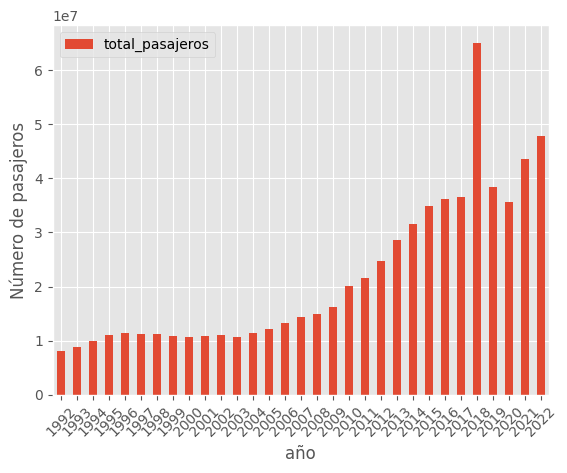

In [34]:
pasajeros_anho["año"] = pasajeros_anho["año"].astype("Int64")
pasajeros_anho.dropna(inplace=True)
plt.figure(figsize=(12,20))
pasajeros_anho.set_index("año").sort_index().plot(kind="bar")
plt.ylabel("Número de pasajeros")
plt.xticks(rotation=45);

Text(0, 0.5, 'Nombre empresa')

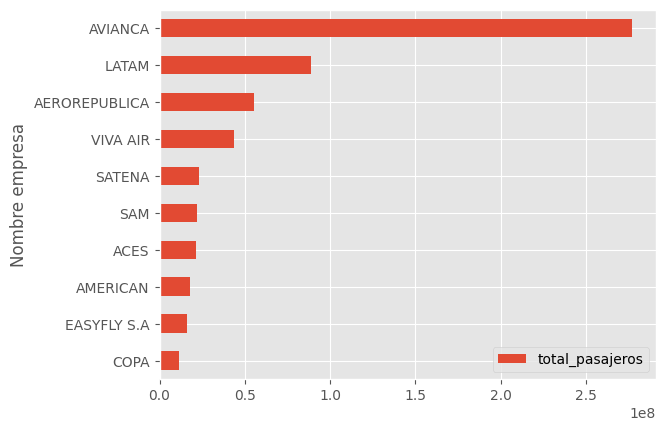

In [35]:
pasajeros_empresa.dropna(inplace=True)

pasajeros_empresa.sort_values("total_pasajeros", ascending=False)[:10].sort_values("total_pasajeros").set_index("Nombre_Empresa_clean").plot(kind="barh")
plt.ylabel("Nombre empresa")

In [24]:
top_empresas =pd.DataFrame()
tot_anhos = pasajeros_anho_empresa["año"].unique()
for anho in tot_anhos:
    ind = pasajeros_anho_empresa["año"] ==anho
    tmp = pasajeros_anho_empresa.loc[ind,:].sort_values("total_pasajeros", ascending=False).iloc[:10,:]
    top_empresas = pd.concat([top_empresas,tmp ])
top_empresas = top_empresas.sort_values("año")

In [25]:
top_empresas_nacional =pd.DataFrame()
tot_anhos_nacional = pasajeros_anho_empresa_nacional["año"].unique()
for anho in tot_anhos_nacional:
    ind = pasajeros_anho_empresa_nacional["año"] ==anho
    tmp = pasajeros_anho_empresa_nacional.loc[ind,:].sort_values("total_pasajeros", ascending=False).iloc[:10,:]
    top_empresas_nacional = pd.concat([top_empresas_nacional,tmp ])
top_empresas_nacional = top_empresas_nacional.sort_values("año")

**IpyVizzu**

In [26]:
 # data processing, CSV file I/O (e.g. pd.read_csv)
from ipyvizzu import Chart, Data, Config, Style
char_data = Data()
char_data.add_data_frame(top_empresas_nacional) #Adds data to chart
chart = Chart(display = "begin")
chart.scroll_into_view = False


chart.animate(char_data)
config = {
    "channels": {
        "x": {"set": ["total_pasajeros"]},
        "y": {"set": ["Nombre_Empresa_clean"]},
        "color": {"set": ["Nombre_Empresa_clean"]},
        "label": { "set": ["total_pasajeros"] }
    },
    "sort": 'byValue',
    "legend": None,
}

style= Style({"plot": 
    {"marker": {"colorPalette": "#008080 #b5e48cff #99D986 #76c893ff #52b69aff"
                + " #34a0a4ff #168aadff #1a759fff #1e6091ff #184e77ff",
                "label": {"maxFractionDigits": "0"}}, #cutting off unnecessary digits when animating the labels
      "paddingLeft":"18em", #add padding on the left side of the plot so that long country names are visible
      "xAxis": { "title": { "color" : "#00000000" }} #hiding the axis title on the x-axis
    }})

#Renders the animation for each year
for anho in range(1992, 2023):
    config["title"] = f"Número de pasajeros por aerolínea en {anho}"
    chart.animate(
        Data.filter("record['año'] == {}".format(anho)), 
        Config(config),
        style,
        # Animation options:
        duration = .9,        
        x = { "easing": "linear", "delay": 0 },
        y = { "delay": 0 },
        show = { "delay": 0 },
        hide = { "delay": 0 },
        title = { "duration": 0, "delay": 0 })
 


In [27]:
char_data = Data()
char_data.add_data_frame(top_empresas_nacional) 
chart = Chart(display = "begin")
chart.scroll_into_view = False


chart.animate(char_data)
config = {
    "channels": {
        "x": {"set": ["total_pasajeros"]},
        "y": {"set": ["Nombre_Empresa_clean"]},
        "color": {"set": ["Nombre_Empresa_clean"]},
        "label": { "set": ["total_pasajeros"] }
    },
    "sort": 'byValue',
    "legend": None,
}

style= Style({"plot": 
    {"marker": {"colorPalette": "#d9ed92ff #b5e48cff #99D986 #76c893ff #52b69aff"
                + " #34a0a4ff #168aadff #1a759fff #1e6091ff #184e77ff",
                "label": {"maxFractionDigits": "0"}}, #cutting off unnecessary digits when animating the labels
      "paddingLeft":"19em", #add padding on the left side of the plot so that long country names are visible
      "xAxis": { "title": { "color" : "#00000000" }} #hiding the axis title on the x-axis
    }})


for anho in range(1992, 2023):
    config["title"] = f"Número de pasajeros por aerolínea en {anho}"
    chart.animate(
        Data.filter("record['año'] == {}".format(anho)), 
        Config(config),
        style,
        # Animation options:
        duration = .8,        
        x = { "easing": "linear", "delay": 0 },
        y = { "delay": 0 },
        show = { "delay": 0 },
        hide = { "delay": 0 },
        title = { "duration": 0, "delay": 0 })
 
 


